Loaded 200 images and 200 masks from D:/1/Mohsin/ACDC/database/training.
Loaded 100 images and 100 masks from D:/1/Mohsin/ACDC/database/testing.
Epoch 1/10, Loss: 0.5114605575799942
Epoch 2/10, Loss: 0.47749326229095457
Epoch 3/10, Loss: 0.4458081156015396
Epoch 4/10, Loss: 0.4147760823369026
Epoch 5/10, Loss: 0.38745884150266646
Epoch 6/10, Loss: 0.36272104680538175
Epoch 7/10, Loss: 0.3403202772140503
Epoch 8/10, Loss: 0.31890162378549575
Epoch 9/10, Loss: 0.30069465190172195
Epoch 10/10, Loss: 0.28355801701545713
Mean Dice Score: 0.0000


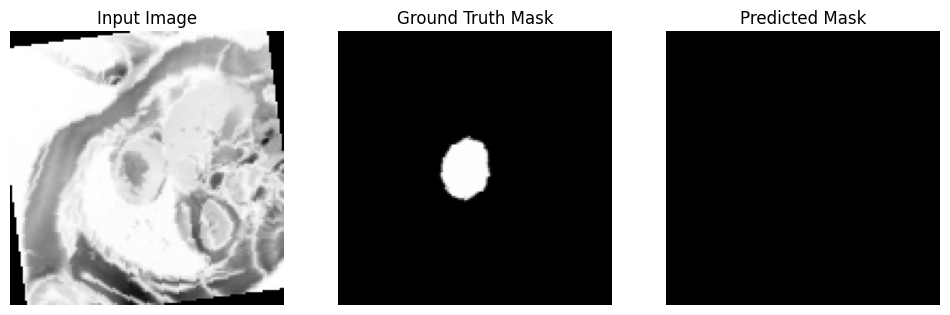

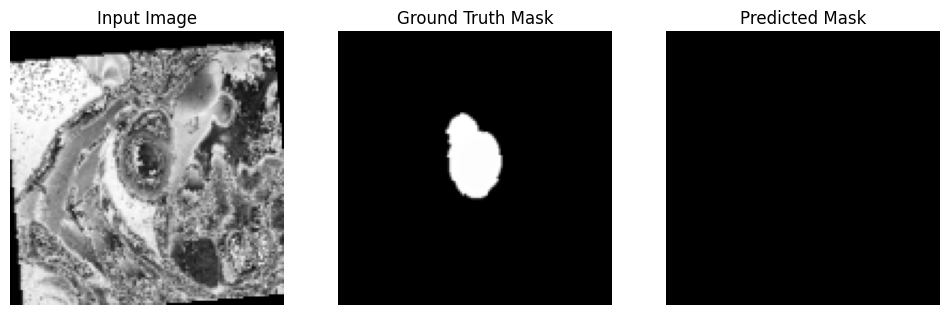

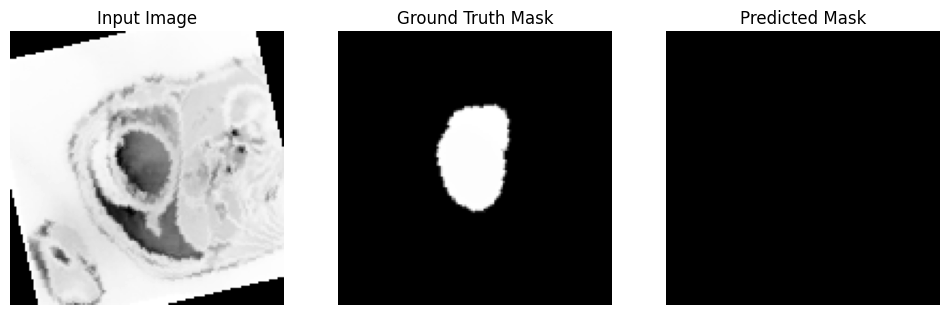

In [13]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms as T
import torch.optim as optim

# Define helper functions and classes
def load_acdc_data(data_path):
    """
    Load images and masks from the ACDC dataset.
    Args:
        data_path (str): Path to the dataset directory (training or testing).
    Returns:
        tuple: Two lists containing paths to images and masks.
    """
    images, masks = [], []

    for patient_folder in os.listdir(data_path):
        patient_path = os.path.join(data_path, patient_folder)
        if os.path.isdir(patient_path):
            for file in os.listdir(patient_path):
                if file.endswith('_gt.nii.gz'):  # Mask files
                    masks.append(os.path.join(patient_path, file))
                elif '_frame' in file and not file.endswith('_gt.nii.gz'):  # Image files
                    images.append(os.path.join(patient_path, file))

    images.sort()
    masks.sort()

    if len(images) != len(masks):
        raise ValueError(f"Mismatch in counts: {len(images)} images and {len(masks)} masks.")

    print(f"Loaded {len(images)} images and {len(masks)} masks from {data_path}.")
    return images, masks

def visualize_sample(image_path, mask_path):
    """
    Visualize the middle slice of an image and its mask.
    """
    image_nii = nib.load(image_path)
    mask_nii = nib.load(mask_path)

    image_data = image_nii.get_fdata()
    mask_data = mask_nii.get_fdata()

    middle_slice = image_data.shape[2] // 2

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_data[:, :, middle_slice], cmap="gray")
    plt.title("MRI Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask_data[:, :, middle_slice], cmap="gray")
    plt.title("Segmentation Mask")
    plt.axis("off")
    plt.show()

class MRIDataset(Dataset):
    def __init__(self, images, masks, image_transforms, mask_transforms):
        self.images = images
        self.masks = masks
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        mask_path = self.masks[idx]

        # Load NIfTI files
        image_data = nib.load(image_path).get_fdata()
        mask_data = nib.load(mask_path).get_fdata()

        # Extract middle slice
        middle_slice = image_data.shape[2] // 2
        image_slice = image_data[:, :, middle_slice]
        mask_slice = mask_data[:, :, middle_slice]

        # Apply transforms
        image_tensor = self.image_transforms(image_slice.astype("float32"))
        mask_tensor = self.mask_transforms(mask_slice.astype("float32"))

        return image_tensor, mask_tensor

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def dice_coefficient(pred, target, epsilon=1e-6):
    intersection = np.sum(pred * target)
    union = np.sum(pred) + np.sum(target)
    dice = (2.0 * intersection + epsilon) / (union + epsilon)
    return dice

# Paths
train_data_path = "D:/1/Mohsin/ACDC/database/training"
test_data_path = "D:/1/Mohsin/ACDC/database/testing"

# Load data
train_images, train_masks = load_acdc_data(train_data_path)
test_images, test_masks = load_acdc_data(test_data_path)

# Split data
train_images_split, val_images, train_masks_split, val_masks = train_test_split(
    train_images, train_masks, test_size=0.2, random_state=42
)

# Define augmentations
image_transforms = T.Compose([
    T.ToPILImage(),
    T.Resize((128, 128)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ToTensor(),
])

mask_transforms = T.Compose([
    T.ToPILImage(),
    T.Resize((128, 128)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ToTensor(),
])

# Create datasets and loaders
train_dataset = MRIDataset(train_images_split, train_masks_split, image_transforms, mask_transforms)
val_dataset = MRIDataset(val_images, val_masks, image_transforms, mask_transforms)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

# Define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        outputs = torch.nn.functional.interpolate(outputs, size=masks.shape[2:])

        # Compute loss
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader)}")

# Evaluate the model on validation set
model.eval()
dice_scores = []
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        outputs = torch.nn.functional.interpolate(outputs, size=masks.shape[2:])
        preds = (outputs > 0.5).float()
        for pred, mask in zip(preds, masks):
            dice_scores.append(dice_coefficient(pred.cpu().numpy(), mask.cpu().numpy()))

print(f"Mean Dice Score: {np.mean(dice_scores):.4f}")

# Visualization function for predictions
def visualize_predictions(model, loader, num_samples=3):
    model.eval()
    count = 0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            outputs = torch.nn.functional.interpolate(outputs, size=masks.shape[2:])
            preds = (outputs > 0.5).float()
            for i in range(images.shape[0]):
                if count >= num_samples:
                    return
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.imshow(images[i, 0].cpu(), cmap="gray")
                plt.title("Input Image")
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.imshow(masks[i, 0].cpu(), cmap="gray")
                plt.title("Ground Truth Mask")
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.imshow(preds[i, 0].cpu(), cmap="gray")
                plt.title("Predicted Mask")
                plt.axis("off")

                plt.show()
                count += 1

# Visualize predictions
visualize_predictions(model, val_loader)


In [14]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms as T
import torch.optim as optim


In [15]:
def load_acdc_data(data_path):
    """
    Load images and masks from the ACDC dataset.
    """
    images, masks = [], []
    for patient_folder in os.listdir(data_path):
        patient_path = os.path.join(data_path, patient_folder)
        if os.path.isdir(patient_path):
            for file in os.listdir(patient_path):
                if file.endswith('_gt.nii.gz'):  # Mask files
                    masks.append(os.path.join(patient_path, file))
                elif '_frame' in file and not file.endswith('_gt.nii.gz'):  # Image files
                    images.append(os.path.join(patient_path, file))
    images.sort()
    masks.sort()
    return images, masks


def visualize_sample(image_path, mask_path):
    """
    Visualize the middle slice of an image and its mask.
    """
    image_nii = nib.load(image_path)
    mask_nii = nib.load(mask_path)
    image_data = image_nii.get_fdata()
    mask_data = mask_nii.get_fdata()
    middle_slice = image_data.shape[2] // 2

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_data[:, :, middle_slice], cmap="gray")
    plt.title("MRI Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask_data[:, :, middle_slice], cmap="gray")
    plt.title("Segmentation Mask")
    plt.axis("off")
    plt.show()


In [16]:
class MRIDataset(Dataset):
    def __init__(self, images, masks, image_transforms, mask_transforms):
        self.images = images
        self.masks = masks
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        mask_path = self.masks[idx]
        image_data = nib.load(image_path).get_fdata()
        mask_data = nib.load(mask_path).get_fdata()

        # Extract middle slice
        middle_slice = image_data.shape[2] // 2
        image_slice = image_data[:, :, middle_slice]
        mask_slice = mask_data[:, :, middle_slice]

        # Normalize mask to [0, 1]
        mask_slice = (mask_slice > 0).astype("float32")

        # Apply transforms
        image_tensor = self.image_transforms(image_slice.astype("float32"))
        mask_tensor = self.mask_transforms(mask_slice)

        return image_tensor, mask_tensor


In [17]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [18]:
def dice_coefficient(pred, target, epsilon=1e-6):
    intersection = np.sum(pred * target)
    union = np.sum(pred) + np.sum(target)
    dice = (2.0 * intersection + epsilon) / (union + epsilon)
    return dice


def iou_coefficient(pred, target, epsilon=1e-6):
    intersection = np.sum(pred * target)
    union = np.sum(pred) + np.sum(target) - intersection
    iou = (intersection + epsilon) / (union + epsilon)
    return iou


In [19]:


image_transforms = T.Compose([
    T.ToPILImage(),
    T.Resize((128, 128)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ToTensor(),
])

mask_transforms = T.Compose([
    T.ToPILImage(),
    T.Resize((128, 128)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ToTensor(),
])


In [20]:
train_data_path = "D:/1/Mohsin/ACDC/database/training"
test_data_path = "D:/1/Mohsin/ACDC/database/testing"

train_images, train_masks = load_acdc_data(train_data_path)
test_images, test_masks = load_acdc_data(test_data_path)

train_images_split, val_images, train_masks_split, val_masks = train_test_split(
    train_images, train_masks, test_size=0.2, random_state=42
)

train_dataset = MRIDataset(train_images_split, train_masks_split, image_transforms, mask_transforms)
val_dataset = MRIDataset(val_images, val_masks, image_transforms, mask_transforms)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()

train_dice_scores = []
train_iou_scores = []
epochs = 10

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        outputs = torch.nn.functional.interpolate(outputs, size=masks.shape[2:])

        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader)}")

    # Validation step
    model.eval()
    dice_scores, iou_scores = [], []
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            outputs = torch.nn.functional.interpolate(outputs, size=masks.shape[2:])
            preds = (outputs > 0.5).float()
            for pred, mask in zip(preds, masks):
                dice_scores.append(dice_coefficient(pred.cpu().numpy(), mask.cpu().numpy()))
                iou_scores.append(iou_coefficient(pred.cpu().numpy(), mask.cpu().numpy()))

    train_dice_scores.append(np.mean(dice_scores))
    train_iou_scores.append(np.mean(iou_scores))
    print(f"Validation Dice Score: {np.mean(dice_scores):.4f}, IOU: {np.mean(iou_scores):.4f}")


Epoch 1/10, Loss: 0.6679079115390778
Validation Dice Score: 0.0184, IOU: 0.0095
Epoch 2/10, Loss: 0.6262133002281189
Validation Dice Score: 0.0010, IOU: 0.0005
Epoch 3/10, Loss: 0.5861685603857041
Validation Dice Score: 0.0000, IOU: 0.0000
Epoch 4/10, Loss: 0.5476263701915741
Validation Dice Score: 0.0000, IOU: 0.0000
Epoch 5/10, Loss: 0.5113987177610397
Validation Dice Score: 0.0000, IOU: 0.0000
Epoch 6/10, Loss: 0.4771810010075569
Validation Dice Score: 0.0000, IOU: 0.0000
Epoch 7/10, Loss: 0.44397205859422684
Validation Dice Score: 0.0000, IOU: 0.0000
Epoch 8/10, Loss: 0.4145244017243385
Validation Dice Score: 0.0000, IOU: 0.0000
Epoch 9/10, Loss: 0.38660572469234467
Validation Dice Score: 0.0000, IOU: 0.0000
Epoch 10/10, Loss: 0.36077014803886415
Validation Dice Score: 0.0000, IOU: 0.0000


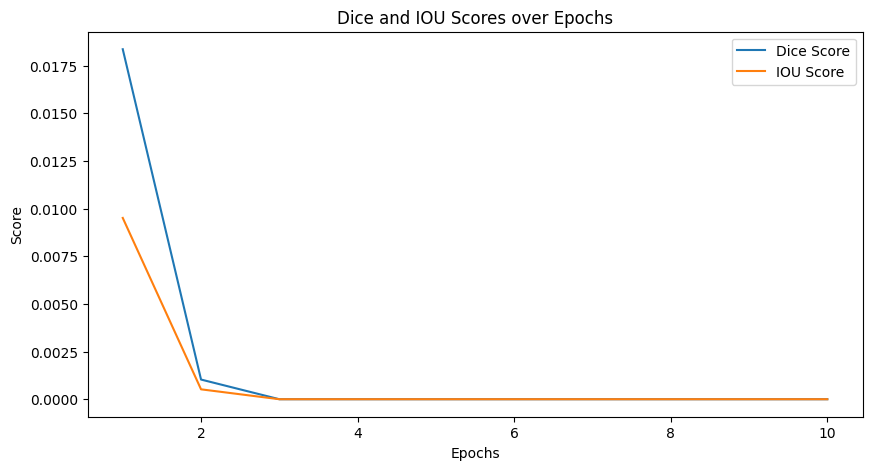

In [22]:
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_dice_scores, label="Dice Score")
plt.plot(epochs_range, train_iou_scores, label="IOU Score")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Dice and IOU Scores over Epochs")
plt.legend()
plt.show()


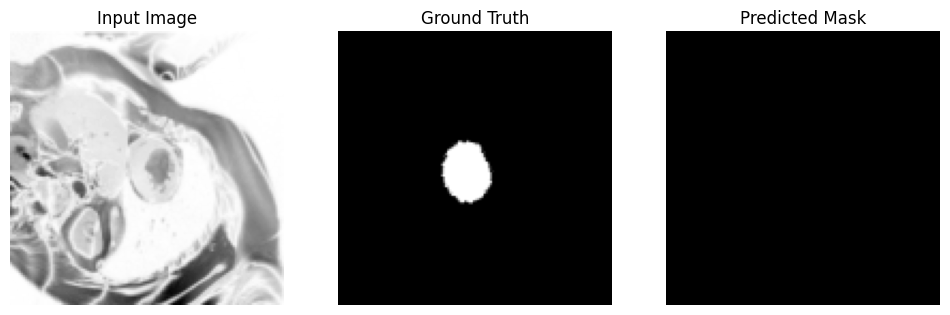

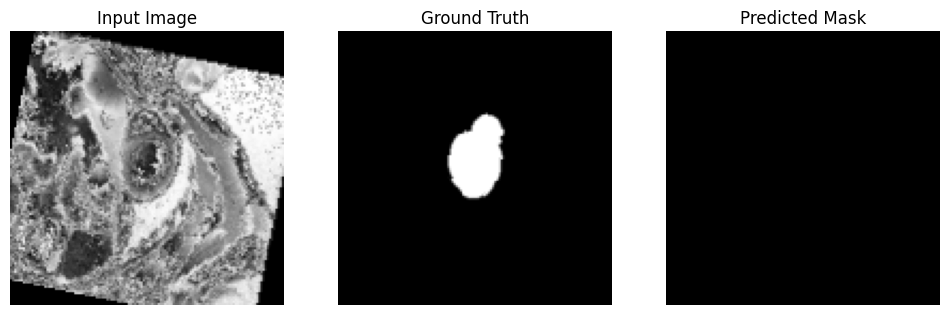

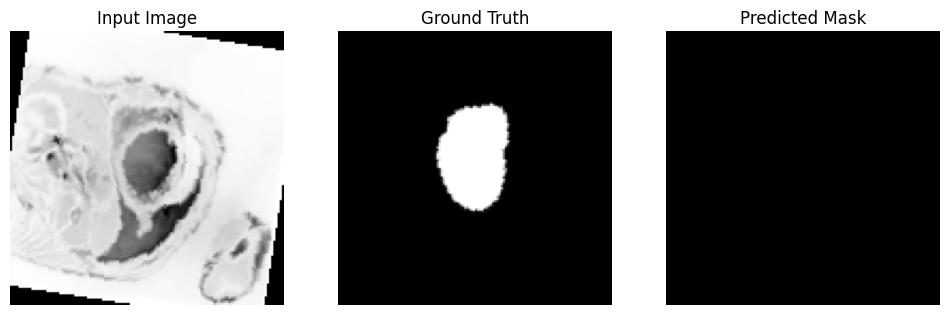

In [23]:
def visualize_predictions(model, loader, num_samples=3):
    model.eval()
    count = 0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            outputs = torch.nn.functional.interpolate(outputs, size=masks.shape[2:])
            preds = (outputs > 0.5).float()

            for i in range(images.shape[0]):
                if count >= num_samples:
                    return
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.imshow(images[i, 0].cpu(), cmap="gray")
                plt.title("Input Image")
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.imshow(masks[i, 0].cpu(), cmap="gray")
                plt.title("Ground Truth")
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.imshow(preds[i, 0].cpu(), cmap="gray")
                plt.title("Predicted Mask")
                plt.axis("off")

                plt.show()
                count += 1

visualize_predictions(model, val_loader)


Loaded 200 images and 200 masks from D:/1/Mohsin/ACDC/database/training.
Loaded 100 images and 100 masks from D:/1/Mohsin/ACDC/database/testing.


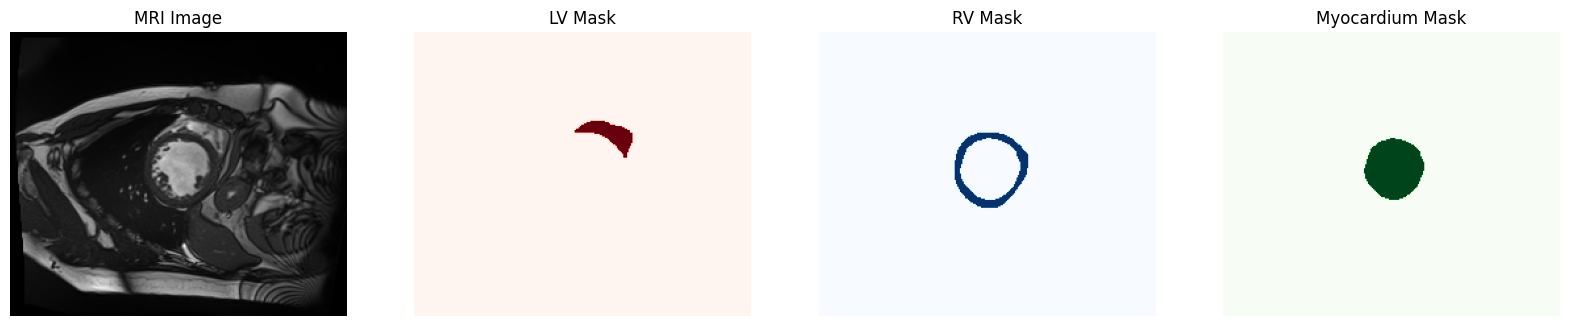

In [30]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchvision import transforms as T

# Step 1: Load ACDC Data with Multi-Class Support
def load_acdc_data(data_path):
    """
    Load images and masks from the ACDC dataset.
    Args:
        data_path (str): Path to the dataset directory (training or testing).
    Returns:
        tuple: Two lists containing paths to images and masks.
    """
    images, masks = [], []

    for patient_folder in os.listdir(data_path):
        patient_path = os.path.join(data_path, patient_folder)
        if os.path.isdir(patient_path):
            for file in os.listdir(patient_path):
                if file.endswith('_gt.nii.gz'):  # Mask files
                    masks.append(os.path.join(patient_path, file))
                elif '_frame' in file and not file.endswith('_gt.nii.gz'):  # Image files
                    images.append(os.path.join(patient_path, file))

    images.sort()
    masks.sort()

    if len(images) != len(masks):
        raise ValueError(f"Mismatch in counts: {len(images)} images and {len(masks)} masks.")

    print(f"Loaded {len(images)} images and {len(masks)} masks from {data_path}.")
    return images, masks

# Paths
train_data_path = "D:/1/Mohsin/ACDC/database/training"
test_data_path = "D:/1/Mohsin/ACDC/database/testing"

# Load data
train_images, train_masks = load_acdc_data(train_data_path)
test_images, test_masks = load_acdc_data(test_data_path)

# Step 2: Visualize LV, RV, and Myocardium

def visualize_sample(image_path, mask_path):
    """
    Visualize the middle slice of an image and its multi-class mask (LV, RV, Myocardium).
    """
    image_nii = nib.load(image_path)
    mask_nii = nib.load(mask_path)

    image_data = image_nii.get_fdata()
    mask_data = mask_nii.get_fdata()

    middle_slice = image_data.shape[2] // 2

    # Extract classes from the mask
    lv_mask = (mask_data[:, :, middle_slice] == 1).astype(float)
    rv_mask = (mask_data[:, :, middle_slice] == 2).astype(float)
    myo_mask = (mask_data[:, :, middle_slice] == 3).astype(float)

    plt.figure(figsize=(20, 5))
    
    # MRI Image
    plt.subplot(1, 4, 1)
    plt.imshow(image_data[:, :, middle_slice], cmap="gray")
    plt.title("MRI Image")
    plt.axis("off")

    # LV Mask
    plt.subplot(1, 4, 2)
    plt.imshow(lv_mask, cmap="Reds")
    plt.title("LV Mask")
    plt.axis("off")

    # RV Mask
    plt.subplot(1, 4, 3)
    plt.imshow(rv_mask, cmap="Blues")
    plt.title("RV Mask")
    plt.axis("off")

    # Myocardium Mask
    plt.subplot(1, 4, 4)
    plt.imshow(myo_mask, cmap="Greens")
    plt.title("Myocardium Mask")
    plt.axis("off")

    plt.show()

# Visualize a training sample
visualize_sample(train_images[0], train_masks[0])


Loaded 200 images and 200 masks from D:/1/Mohsin/ACDC/database/training.
Loaded 100 images and 100 masks from D:/1/Mohsin/ACDC/database/testing.


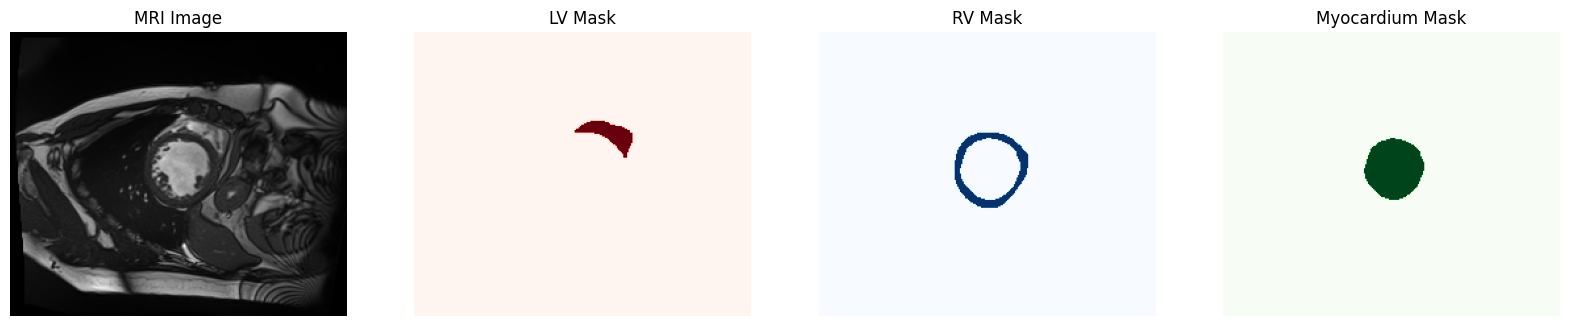

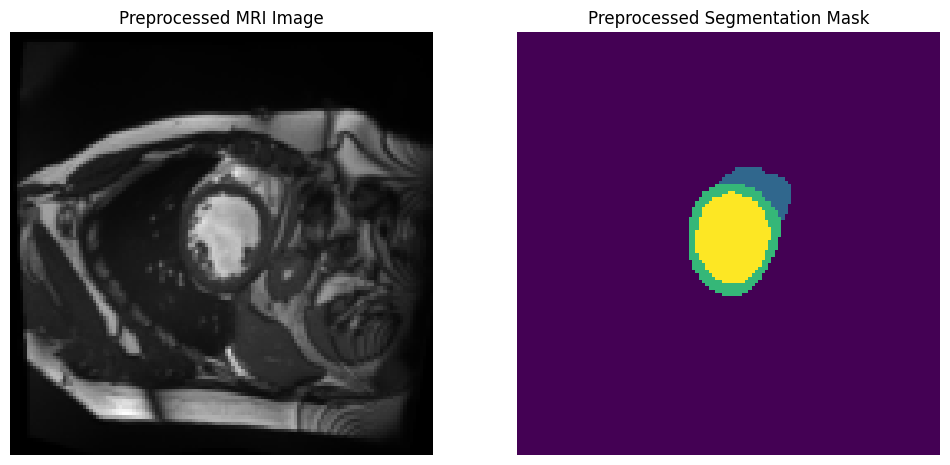

In [31]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchvision import transforms as T

# Step 1: Load ACDC Data with Multi-Class Support
def load_acdc_data(data_path):
    """
    Load images and masks from the ACDC dataset.
    Args:
        data_path (str): Path to the dataset directory (training or testing).
    Returns:
        tuple: Two lists containing paths to images and masks.
    """
    images, masks = [], []

    for patient_folder in os.listdir(data_path):
        patient_path = os.path.join(data_path, patient_folder)
        if os.path.isdir(patient_path):
            for file in os.listdir(patient_path):
                if file.endswith('_gt.nii.gz'):  # Mask files
                    masks.append(os.path.join(patient_path, file))
                elif '_frame' in file and not file.endswith('_gt.nii.gz'):  # Image files
                    images.append(os.path.join(patient_path, file))

    images.sort()
    masks.sort()

    if len(images) != len(masks):
        raise ValueError(f"Mismatch in counts: {len(images)} images and {len(masks)} masks.")

    print(f"Loaded {len(images)} images and {len(masks)} masks from {data_path}.")
    return images, masks

# Paths
train_data_path = "D:/1/Mohsin/ACDC/database/training"
test_data_path = "D:/1/Mohsin/ACDC/database/testing"

# Load data
train_images, train_masks = load_acdc_data(train_data_path)
test_images, test_masks = load_acdc_data(test_data_path)

# Step 2: Visualize LV, RV, and Myocardium

def visualize_sample(image_path, mask_path):
    """
    Visualize the middle slice of an image and its multi-class mask (LV, RV, Myocardium).
    """
    image_nii = nib.load(image_path)
    mask_nii = nib.load(mask_path)

    image_data = image_nii.get_fdata()
    mask_data = mask_nii.get_fdata()

    middle_slice = image_data.shape[2] // 2

    # Extract classes from the mask
    lv_mask = (mask_data[:, :, middle_slice] == 1).astype(float)
    rv_mask = (mask_data[:, :, middle_slice] == 2).astype(float)
    myo_mask = (mask_data[:, :, middle_slice] == 3).astype(float)

    plt.figure(figsize=(20, 5))
    
    # MRI Image
    plt.subplot(1, 4, 1)
    plt.imshow(image_data[:, :, middle_slice], cmap="gray")
    plt.title("MRI Image")
    plt.axis("off")

    # LV Mask
    plt.subplot(1, 4, 2)
    plt.imshow(lv_mask, cmap="Reds")
    plt.title("LV Mask")
    plt.axis("off")

    # RV Mask
    plt.subplot(1, 4, 3)
    plt.imshow(rv_mask, cmap="Blues")
    plt.title("RV Mask")
    plt.axis("off")

    # Myocardium Mask
    plt.subplot(1, 4, 4)
    plt.imshow(myo_mask, cmap="Greens")
    plt.title("Myocardium Mask")
    plt.axis("off")

    plt.show()

# Visualize a training sample
visualize_sample(train_images[0], train_masks[0])

# Step 3: Data Preprocessing
def preprocess_data(image_path, mask_path, target_size=(128, 128)):
    """
    Preprocess the image and mask by resizing and normalizing.
    Args:
        image_path (str): Path to the MRI image.
        mask_path (str): Path to the segmentation mask.
        target_size (tuple): Target size for resizing (height, width).
    Returns:
        tuple: Preprocessed image and mask.
    """
    image_nii = nib.load(image_path)
    mask_nii = nib.load(mask_path)

    image_data = image_nii.get_fdata()
    mask_data = mask_nii.get_fdata()

    middle_slice = image_data.shape[2] // 2

    image_slice = image_data[:, :, middle_slice]
    mask_slice = mask_data[:, :, middle_slice]

    # Normalize image
    image_slice = (image_slice - np.min(image_slice)) / (np.max(image_slice) - np.min(image_slice))

    # Resize image and mask
    image_resized = T.functional.resize(torch.tensor(image_slice).unsqueeze(0), target_size)
    mask_resized = T.functional.resize(torch.tensor(mask_slice).unsqueeze(0), target_size, interpolation=T.InterpolationMode.NEAREST)

    return image_resized.squeeze(0).numpy(), mask_resized.squeeze(0).numpy()

# Preprocess a sample
preprocessed_image, preprocessed_mask = preprocess_data(train_images[0], train_masks[0])

# Step 4: Visualize Preprocessed Data
plt.figure(figsize=(12, 6))

# Preprocessed Image
plt.subplot(1, 2, 1)
plt.imshow(preprocessed_image, cmap="gray")
plt.title("Preprocessed MRI Image")
plt.axis("off")

# Preprocessed Mask
plt.subplot(1, 2, 2)
plt.imshow(preprocessed_mask, cmap="viridis")
plt.title("Preprocessed Segmentation Mask")
plt.axis("off")

plt.show()

Loaded 200 images and 200 masks from D:/1/Mohsin/ACDC/database/training.
Loaded 100 images and 100 masks from D:/1/Mohsin/ACDC/database/testing.


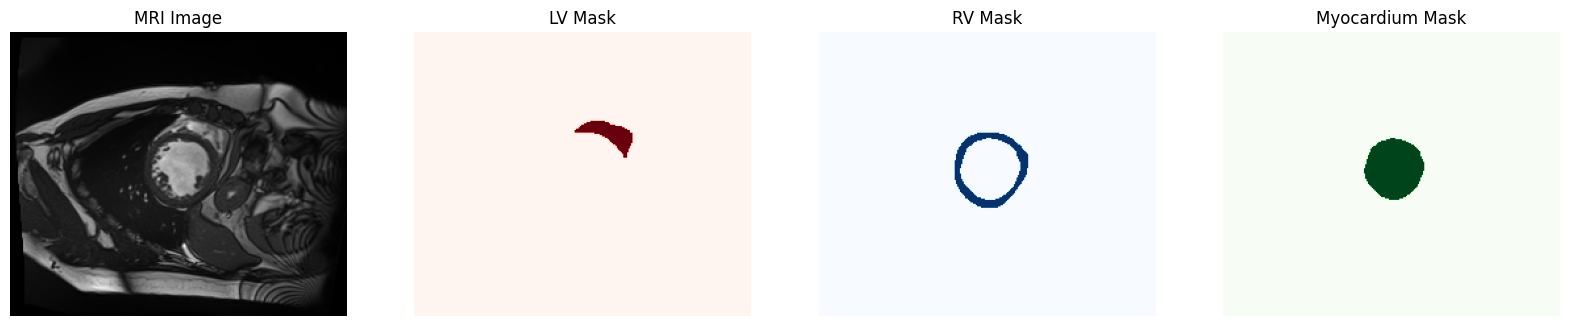

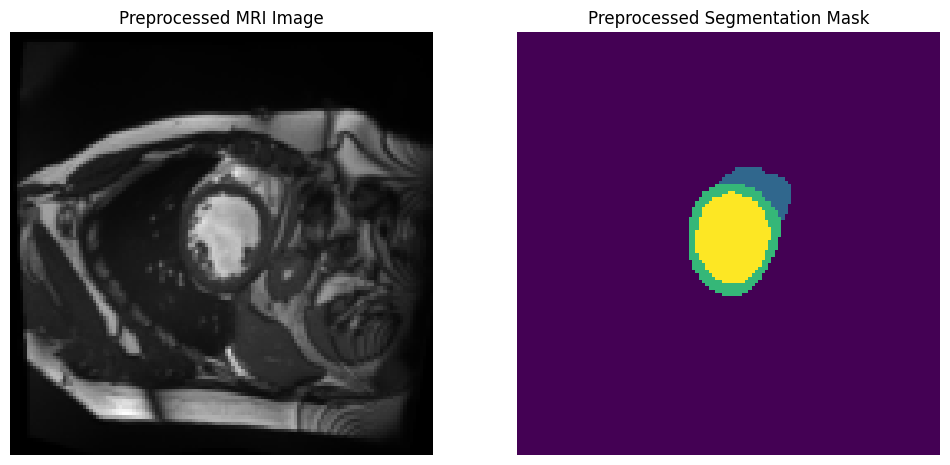

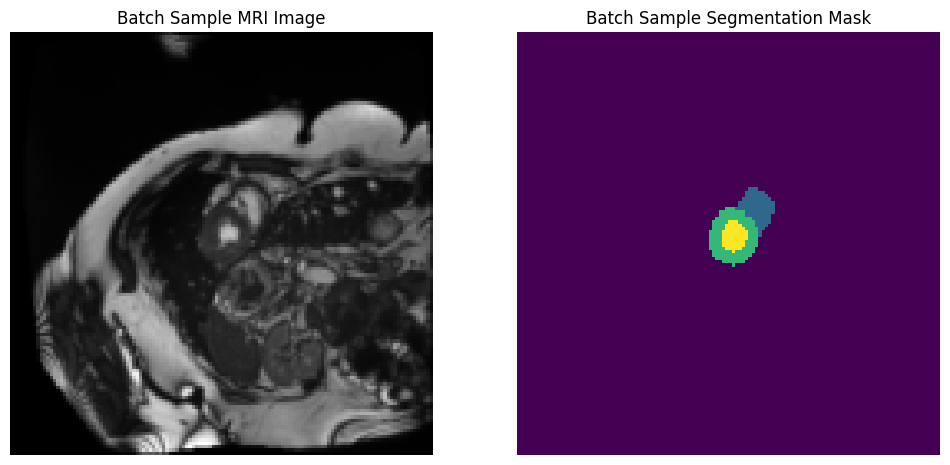

In [32]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchvision import transforms as T

# Step 1: Load ACDC Data with Multi-Class Support
def load_acdc_data(data_path):
    """
    Load images and masks from the ACDC dataset.
    Args:
        data_path (str): Path to the dataset directory (training or testing).
    Returns:
        tuple: Two lists containing paths to images and masks.
    """
    images, masks = [], []

    for patient_folder in os.listdir(data_path):
        patient_path = os.path.join(data_path, patient_folder)
        if os.path.isdir(patient_path):
            for file in os.listdir(patient_path):
                if file.endswith('_gt.nii.gz'):  # Mask files
                    masks.append(os.path.join(patient_path, file))
                elif '_frame' in file and not file.endswith('_gt.nii.gz'):  # Image files
                    images.append(os.path.join(patient_path, file))

    images.sort()
    masks.sort()

    if len(images) != len(masks):
        raise ValueError(f"Mismatch in counts: {len(images)} images and {len(masks)} masks.")

    print(f"Loaded {len(images)} images and {len(masks)} masks from {data_path}.")
    return images, masks

# Paths
train_data_path = "D:/1/Mohsin/ACDC/database/training"
test_data_path = "D:/1/Mohsin/ACDC/database/testing"

# Load data
train_images, train_masks = load_acdc_data(train_data_path)
test_images, test_masks = load_acdc_data(test_data_path)

# Step 2: Visualize LV, RV, and Myocardium

def visualize_sample(image_path, mask_path):
    """
    Visualize the middle slice of an image and its multi-class mask (LV, RV, Myocardium).
    """
    image_nii = nib.load(image_path)
    mask_nii = nib.load(mask_path)

    image_data = image_nii.get_fdata()
    mask_data = mask_nii.get_fdata()

    middle_slice = image_data.shape[2] // 2

    # Extract classes from the mask
    lv_mask = (mask_data[:, :, middle_slice] == 1).astype(float)
    rv_mask = (mask_data[:, :, middle_slice] == 2).astype(float)
    myo_mask = (mask_data[:, :, middle_slice] == 3).astype(float)

    plt.figure(figsize=(20, 5))
    
    # MRI Image
    plt.subplot(1, 4, 1)
    plt.imshow(image_data[:, :, middle_slice], cmap="gray")
    plt.title("MRI Image")
    plt.axis("off")

    # LV Mask
    plt.subplot(1, 4, 2)
    plt.imshow(lv_mask, cmap="Reds")
    plt.title("LV Mask")
    plt.axis("off")

    # RV Mask
    plt.subplot(1, 4, 3)
    plt.imshow(rv_mask, cmap="Blues")
    plt.title("RV Mask")
    plt.axis("off")

    # Myocardium Mask
    plt.subplot(1, 4, 4)
    plt.imshow(myo_mask, cmap="Greens")
    plt.title("Myocardium Mask")
    plt.axis("off")

    plt.show()

# Visualize a training sample
visualize_sample(train_images[0], train_masks[0])

# Step 3: Data Preprocessing
def preprocess_data(image_path, mask_path, target_size=(128, 128)):
    """
    Preprocess the image and mask by resizing and normalizing.
    Args:
        image_path (str): Path to the MRI image.
        mask_path (str): Path to the segmentation mask.
        target_size (tuple): Target size for resizing (height, width).
    Returns:
        tuple: Preprocessed image and mask.
    """
    image_nii = nib.load(image_path)
    mask_nii = nib.load(mask_path)

    image_data = image_nii.get_fdata()
    mask_data = mask_nii.get_fdata()

    middle_slice = image_data.shape[2] // 2

    image_slice = image_data[:, :, middle_slice]
    mask_slice = mask_data[:, :, middle_slice]

    # Normalize image
    image_slice = (image_slice - np.min(image_slice)) / (np.max(image_slice) - np.min(image_slice))

    # Resize image and mask
    image_resized = T.functional.resize(torch.tensor(image_slice).unsqueeze(0), target_size)
    mask_resized = T.functional.resize(torch.tensor(mask_slice).unsqueeze(0), target_size, interpolation=T.InterpolationMode.NEAREST)

    return image_resized.squeeze(0).numpy(), mask_resized.squeeze(0).numpy()

# Preprocess a sample
preprocessed_image, preprocessed_mask = preprocess_data(train_images[0], train_masks[0])

# Step 4: Visualize Preprocessed Data
plt.figure(figsize=(12, 6))

# Preprocessed Image
plt.subplot(1, 2, 1)
plt.imshow(preprocessed_image, cmap="gray")
plt.title("Preprocessed MRI Image")
plt.axis("off")

# Preprocessed Mask
plt.subplot(1, 2, 2)
plt.imshow(preprocessed_mask, cmap="viridis")
plt.title("Preprocessed Segmentation Mask")
plt.axis("off")

plt.show()

# Step 5: Dataset and DataLoader Classes
class CardiacDataset(Dataset):
    def __init__(self, image_paths, mask_paths, target_size=(128, 128)):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.target_size = target_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        
        image, mask = preprocess_data(image_path, mask_path, self.target_size)

        # Convert to tensors
        image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        mask_tensor = torch.tensor(mask, dtype=torch.long)  # Masks as class indices

        return image_tensor, mask_tensor

# Create Dataset and DataLoader
train_dataset = CardiacDataset(train_images, train_masks)
test_dataset = CardiacDataset(test_images, test_masks)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Step 6: Visualize DataLoader Output
sample_image, sample_mask = next(iter(train_loader))

# Visualize one batch of data
plt.figure(figsize=(12, 6))

# First image in the batch
plt.subplot(1, 2, 1)
plt.imshow(sample_image[0, 0], cmap="gray")  # First channel of the first image
plt.title("Batch Sample MRI Image")
plt.axis("off")

# Corresponding mask
plt.subplot(1, 2, 2)
plt.imshow(sample_mask[0], cmap="viridis")
plt.title("Batch Sample Segmentation Mask")
plt.axis("off")

plt.show()


In [33]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=4):
        super(UNet, self).__init__()
        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        
        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)
        
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = conv_block(512, 1024)
        
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)
        
        self.final_layer = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))
        
        bottleneck = self.bottleneck(self.pool(enc4))
        
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((enc4, dec4), dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((enc3, dec3), dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((enc2, dec2), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((enc1, dec1), dim=1)
        dec1 = self.decoder1(dec1)
        
        return self.final_layer(dec1)

# Initialize model
model = UNet()
print(model)


UNet(
  (encoder1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=2, strid

In [34]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Multi-class segmentation
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
# Training loop
def train_model(model, train_loader, criterion, optimizer, num_epochs=10, device='cpu'):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs=10, device='cuda' if torch.cuda.is_available() else 'cpu')


Epoch 1/10, Loss: 1.3197
Epoch 2/10, Loss: 0.3545


In [ ]:
# Test function
def test_model(model, test_loader, device='cpu'):
    model.eval()
    all_preds, all_masks = [], []

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            
            # Forward pass
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu())
            all_masks.append(masks.cpu())

    return torch.cat(all_preds), torch.cat(all_masks)

# Run test and visualize predictions
test_preds, test_masks = test_model(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu')

# Visualize predictions
def visualize_predictions(images, masks, preds, num_samples=5):
    for i in range(num_samples):
        plt.figure(figsize=(12, 4))

        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(images[i, 0], cmap="gray")
        plt.title("MRI Image")
        plt.axis("off")

        # Ground truth mask
        plt.subplot(1, 3, 2)
        plt.imshow(masks[i], cmap="viridis")
        plt.title("Ground Truth")
        plt.axis("off")

        # Predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(preds[i], cmap="viridis")
        plt.title("Prediction")
        plt.axis("off")

        plt.show()

# Visualize some samples
sample_images, sample_masks = next(iter(test_loader))
visualize_predictions(sample_images.numpy(), sample_masks.numpy(), test_preds[:5].numpy())


In [ ]:
# Dice coefficient
def dice_score(preds, targets, num_classes=4):
    scores = []
    for c in range(num_classes):
        pred_class = (preds == c).float()
        target_class = (targets == c).float()

        intersection = (pred_class * target_class).sum()
        union = pred_class.sum() + target_class.sum()

        dice = (2.0 * intersection) / (union + 1e-5)
        scores.append(dice.item())

    return scores

# Calculate Dice scores
dice_scores = dice_score(test_preds, test_masks)
for i, score in enumerate(dice_scores):
    print(f"Dice Score for Class {i}: {score:.4f}")


In [ ]:
# Validation function
def validate_model(model, val_loader, criterion, device='cpu'):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    all_preds = []
    all_masks = []

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            # Store predictions and ground truths
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu())
            all_masks.append(masks.cpu())
    
    val_loss /= len(val_loader)
    return val_loss, torch.cat(all_preds), torch.cat(all_masks)


In [ ]:
# Train and validate with visualization
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cpu'):
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        val_loss, _, _ = validate_model(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

# Split train dataset for validation
train_split, val_split = train_test_split(train_dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_split, batch_size=8, shuffle=True)
val_loader = DataLoader(val_split, batch_size=8, shuffle=False)

# Train and validate the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device=device)


In [ ]:
# Test function
def test_model(model, test_loader, device='cpu'):
    model.eval()
    all_preds, all_masks = [], []

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            
            # Forward pass
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu())
            all_masks.append(masks.cpu())

    return torch.cat(all_preds), torch.cat(all_masks)

# Run test
test_preds, test_masks = test_model(model, test_loader, device=device)


In [ ]:
# Visualize predictions
def visualize_predictions(images, masks, preds, num_samples=5):
    for i in range(num_samples):
        plt.figure(figsize=(12, 4))

        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(images[i, 0], cmap="gray")
        plt.title("MRI Image")
        plt.axis("off")

        # Ground truth mask
        plt.subplot(1, 3, 2)
        plt.imshow(masks[i], cmap="viridis")
        plt.title("Ground Truth")
        plt.axis("off")

        # Predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(preds[i], cmap="viridis")
        plt.title("Prediction")
        plt.axis("off")

        plt.show()

# Visualize some test samples
sample_images, sample_masks = next(iter(test_loader))
visualize_predictions(sample_images.numpy(), sample_masks.numpy(), test_preds[:5].numpy())


In [ ]:
# Dice coefficient
def dice_score(preds, targets, num_classes=4):
    scores = []
    for c in range(num_classes):
        pred_class = (preds == c).float()
        target_class = (targets == c).float()

        intersection = (pred_class * target_class).sum()
        union = pred_class.sum() + target_class.sum()

        dice = (2.0 * intersection) / (union + 1e-5)
        scores.append(dice.item())

    return scores

# Calculate Dice scores
dice_scores = dice_score(test_preds, test_masks)
for i, score in enumerate(dice_scores):
    print(f"Dice Score for Class {i}: {score:.4f}")


In [ ]:
# Visualize predictions for each class
def visualize_class_predictions(images, masks, preds, num_samples=3):
    class_names = ["Background", "LV", "RV", "Myocardium"]

    for i in range(num_samples):
        plt.figure(figsize=(20, 8))

        # Original MRI Image
        plt.subplot(1, 5, 1)
        plt.imshow(images[i, 0], cmap="gray")
        plt.title("MRI Image")
        plt.axis("off")

        for c in range(1, 4):  # Class 1, 2, 3
            # Ground truth mask for the class
            plt.subplot(1, 5, c + 1)
            plt.imshow(masks[i] == c, cmap="Reds" if c == 1 else "Blues" if c == 2 else "Greens")
            plt.title(f"Ground Truth: {class_names[c]}")
            plt.axis("off")

            # Predicted mask for the class
            plt.subplot(1, 5, c + 3)
            plt.imshow(preds[i] == c, cmap="Reds" if c == 1 else "Blues" if c == 2 else "Greens")
            plt.title(f"Prediction: {class_names[c]}")
            plt.axis("off")

        plt.tight_layout()
        plt.show()

# Visualize a few samples from the test set
sample_images, sample_masks = next(iter(test_loader))
visualize_class_predictions(sample_images.numpy(), sample_masks.numpy(), test_preds[:3].numpy())


In [ ]:
# Class-wise Dice scores for test set
def plot_class_dice_scores(preds, masks, num_classes=4):
    class_names = ["Background", "LV", "RV", "Myocardium"]
    scores = dice_score(preds, masks, num_classes)

    # Print and plot scores
    for i, score in enumerate(scores):
        print(f"Dice Score for {class_names[i]}: {score:.4f}")

    plt.bar(class_names, scores, color=["gray", "red", "blue", "green"])
    plt.ylabel("Dice Score")
    plt.title("Class-Wise Dice Scores")
    plt.ylim(0, 1)
    plt.show()

# Calculate and plot Dice scores
plot_class_dice_scores(test_preds, test_masks)


In [ ]:
# Overlay predictions on MRI images
def overlay_predictions(images, masks, preds, num_samples=3):
    for i in range(num_samples):
        plt.figure(figsize=(15, 5))

        # Original MRI Image
        plt.subplot(1, 3, 1)
        plt.imshow(images[i, 0], cmap="gray")
        plt.title("MRI Image")
        plt.axis("off")

        # Ground truth overlay
        plt.subplot(1, 3, 2)
        plt.imshow(images[i, 0], cmap="gray")
        plt.imshow(masks[i], alpha=0.5, cmap="viridis")
        plt.title("Ground Truth Overlay")
        plt.axis("off")

        # Prediction overlay
        plt.subplot(1, 3, 3)
        plt.imshow(images[i, 0], cmap="gray")
        plt.imshow(preds[i], alpha=0.5, cmap="viridis")
        plt.title("Prediction Overlay")
        plt.axis("off")

        plt.show()

# Visualize overlays for test samples
overlay_predictions(sample_images.numpy(), sample_masks.numpy(), test_preds[:3].numpy())


In [ ]:
# Calculate per-slice Dice scores
def per_slice_dice_scores(preds, targets, num_classes=4):
    slice_scores = []
    for i in range(len(preds)):
        scores = dice_score(preds[i].unsqueeze(0), targets[i].unsqueeze(0), num_classes)
        slice_scores.append(scores)
    return np.array(slice_scores)

# Compute and plot per-slice scores
slice_scores = per_slice_dice_scores(test_preds, test_masks)

# Plot Dice scores for each class across slices
for c in range(4):  # Classes: Background, LV, RV, Myocardium
    plt.plot(slice_scores[:, c], label=f"Class {c}")
plt.xlabel("Slice Index")
plt.ylabel("Dice Score")
plt.title("Per-Slice Dice Scores")
plt.legend(["Background", "LV", "RV", "Myocardium"])
plt.ylim(0, 1)
plt.show()


In [ ]:
# Overlay predictions on MRI images
def overlay_predictions(images, masks, preds, num_samples=3):
    for i in range(num_samples):
        plt.figure(figsize=(15, 5))

        # Original MRI Image
        plt.subplot(1, 3, 1)
        plt.imshow(images[i, 0], cmap="gray")
        plt.title("MRI Image")
        plt.axis("off")

        # Ground truth overlay
        plt.subplot(1, 3, 2)
        plt.imshow(images[i, 0], cmap="gray")
        plt.imshow(masks[i], alpha=0.5, cmap="viridis")
        plt.title("Ground Truth Overlay")
        plt.axis("off")

        # Prediction overlay
        plt.subplot(1, 3, 3)
        plt.imshow(images[i, 0], cmap="gray")
        plt.imshow(preds[i], alpha=0.5, cmap="viridis")
        plt.title("Prediction Overlay")
        plt.axis("off")

        plt.show()

# Visualize overlays for test samples
overlay_predictions(sample_images.numpy(), sample_masks.numpy(), test_preds[:3].numpy())


In [ ]:
# Calculate per-slice Dice scores
def per_slice_dice_scores(preds, targets, num_classes=4):
    slice_scores = []
    for i in range(len(preds)):
        scores = dice_score(preds[i].unsqueeze(0), targets[i].unsqueeze(0), num_classes)
        slice_scores.append(scores)
    return np.array(slice_scores)

# Compute and plot per-slice scores
slice_scores = per_slice_dice_scores(test_preds, test_masks)

# Plot Dice scores for each class across slices
for c in range(4):  # Classes: Background, LV, RV, Myocardium
    plt.plot(slice_scores[:, c], label=f"Class {c}")
plt.xlabel("Slice Index")
plt.ylabel("Dice Score")
plt.title("Per-Slice Dice Scores")
plt.legend(["Background", "LV", "RV", "Myocardium"])
plt.ylim(0, 1)
plt.show()
